# STORY OF A 4-STATE MODEL

Importantly, in our code we will always use these abbreviations:
- $t$ for time
- $s$ for number of samples
- $x, y$ for states
- $p$ is always for process
- $o$ is always for observable
- $b$ is always for bins, when plotting
- $do$ and $da$ as respectively the domain and the data that we want to collect (often lists)
- $i$, $j$, $k$  as arbitary indices

In [1]:
from storymodel import Process, Observe
from math import exp, log
from matplotlib import pyplot as plt


## Chapter 4: Jump processes
### Initialization
State space:

In [2]:
state = (0, 1, 2, 3)

Input data (rates of Markov process, initial distribution, renormalized):

In [3]:
rates = [[0, 1, 3, 2], [2, 0, 4, 1], [1, 2, 0, 5], [1, 1, 2, 0]]
start = [1, 1, 1, 1.1]

Often we will need to normalize data:

In [4]:
def norm(data):    
    norm = sum(data)
    return [x / norm for x in data]

In fact:

In [5]:
start = norm(start)
print(start)

[0.24390243902439027, 0.24390243902439027, 0.24390243902439027, 0.26829268292682934]


Waiting times, derived Markov chain:

In [6]:
exits = [sum(rates[x]) for x in state]
chain = [[rates[x][y] / exits[x] for y in state] for x in state]

Stationary state (allowing numpy):

In [7]:
import numpy as np

def steady(rates):

    exits = [sum(rates[x]) for x in state]
    steady = []

    for x in state:
        R = np.matrix(rates)-np.diag(exits)
        R = np.delete(R, x, 0)
        R = np.delete(R, x, 1)
        steady.append(-np.linalg.det(R))
        
    steady = [x / sum(steady) for x in steady]

    return steady

You can now check that the result conforms to the spanning-tree formula:

In [8]:
print(steady(rates))

[0.1651376146788991, 0.15596330275229361, 0.24770642201834867, 0.43119266055045874]


### Random choices: discrete variables

Let's choose an initial state from the initial distribution, taking the uniform distribution in the unit interval as the only ingredient:

In [9]:
from random import uniform

def x_choice(prob):
    
    l = len(prob)
    s = [sum(prob[0:x]) for x in range(0,l+1)]
    y = uniform(0, 1)
    for x in range(0,l):
        if y >= s[x] and y < s[x+1]:
            break
    return x

print('I am in ', x_choice(start))

I am in  3


Let's check that the probability distribution is correct. First we introduce the empirical frequency of a symbol in a list of data:

In [10]:
def freq(data):

    dic = {}
    l = len(data)
    for i in data:
        dic[i] = dic.get(i, 0) + 1
    abscissa, ordinate = [], []
    for i in sorted(dic):
        abscissa.append(i)
        ordinate.append(dic[i] / l)
    return abscissa, ordinate

Then we generate 10000 initial states and plot their empirical frequency:

In [11]:
n = 1000
x_list = []

for k in range(n):
    x_list.append(x_choice(start))

x_freq = freq(x_list)

Finally we plot them:

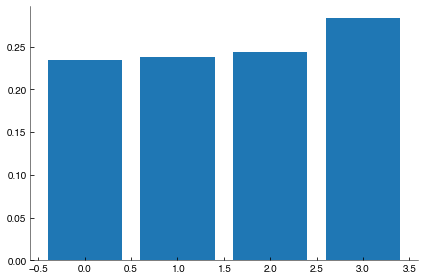

In [12]:
from matplotlib import pyplot as plt

plt.bar(x_freq[0], x_freq[1])
plt.show()

Similarly we can choose where to jump to from given state $x=0$:

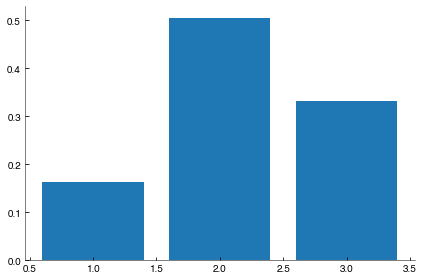

In [13]:
x = 0
y_list = []
for k in range(n):
    y_list.append(x_choice(chain[x]))
y_freq = freq(y_list)
plt.bar(y_freq[0], y_freq[1])
plt.show()

These can be compared with the above rates

### Random choices: waiting time

Similarly we can select the time at random, starting from the uniform distribution, using the inversion method:

In [14]:
from math import log, exp, sqrt

def t_choice(x, exits):
    return log(1 / uniform(0, 1)) / exits[x]

x = x_choice(start)
t = t_choice(x, exits)

print('I will wait', t, 'seconds in', x, 'and then jump.')

I will wait 0.2587668106302991 seconds in 3 and then jump.


Let us now generate lots of waiting times at state $x= 0$:

In [15]:
t_list = []
for k in range(n):
    t_list.append(t_choice(0, exits))

If we were to visualize them as we did above, we would not obtain something very informative:

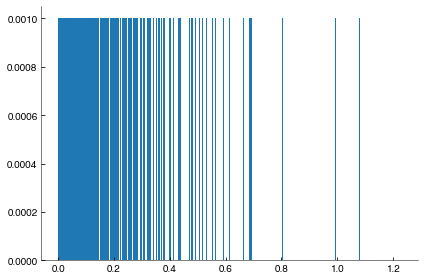

In [16]:
t_freq = freq(t_list)

plt.bar(t_freq[0], t_freq[1], 0.001)
plt.show()

For this reason we need to obtain a continuum distribution:

In [17]:
def pdf(data, bins):

    dic = {}
    l = len(data)
    m = max(data)
    for i in data:
        i = ( (i * bins) // m) * m / bins
        dic[i] = dic.get(i, 0) + 1
    abscissa, ordinate = [], []
    for i in sorted(dic):
        abscissa.append(i)
        ordinate.append(dic[i] / l * bins / m)
    return abscissa, ordinate

And now we can plot the waiting time probabilty density function:

In [ ]:
bins = 100
t_pdf = pdf(t_list, bins)

import numpy as np

abscissa, ordinate = [], []

for k in range(0, bins):
    abscissa.append(k * max(t_list) / bins)
    ordinate.append(exits[0] * exp(- exits[0] * abscissa[k]))

plt.plot(abscissa, ordinate, color = "mediumseagreen")
plt.bar(t_pdf[0], t_pdf[1], .005, color = "darkorange")
plt.show()

Often we will be interested in just the mean and variance of a variable, and not the full distribution. Then:

In [ ]:
def mean(data):

    return sum(data) / len(data)

def variance(data):
    
    return sum([i ** 2 for i in data]) / len(data) - mean(data) ** 2

For example:

In [ ]:
print(mean(t_list))
print(variance(t_list))

## Chapter 6: Single paths

### Coding a trajectory: soujourn times

Most often it will be convenient to hard-program the observable of interest into the trajectory being defined. For example, suppose we want to calculate the average time spent at states. Then we can easily do this with:

In [ ]:
def souj(x, n, d = 1):

    souj = [0 for y in state]

    for k in range(n):
        if k % d == 0:
            souj[x] += t_choice(x, exits)
            x = x_choice(chain[x])

    return [x / sum(souj) for x in souj]

x = 0
n = 10000

print(souj(x, n))
print(steady(rates))

However, we should be careful about numerical errors. There are two sources of error, one systematic and one random.

In [ ]:
x = 0
n = 100
m = 10000
s = []

for j in range(m):
    s.append(souj(x, n)[0])
    
s_mean = sum(s) / m
s_var = sum([i ** 2 for i in s]) / m - s_mean ** 2
s_fano = s_var / s_mean

print(s_fano)


But now:

In [ ]:
n = 10000
d = 100

s = []

for j in range(m):
    s.append(souj(x, n, d)[0])
    
s_mean = sum(s) / m
s_var = sum([i ** 2 for i in s]) / m - s_mean ** 2
s_fano = s_var / s_mean

print(s_fano)

### Tidying up

In fact, later it will be useful to have all of these things as attributes of a process (so that we do not have to recompile the whole notebook all the time...). This is achieved like this:

We can check that this works:

Let us check how the commutator is doing (this should be come a method in the Process class):

In [ ]:
from storymodel import Process

p = Process()

print(p.rates, '\n\n')
print(p.exits, '\n\n')
print(p.chain, '\n\n')
print(p.generator, '\n\n')
print(p.start, '\n\n')
print(p.steady(), '\n\n')

Notice that if no argument is given the system takes the uniform rates by default, and the stationary state as initial state. Notice that all of the above are attributes buy steady, which is a method and it has parenthesis (attributes are calculated automatically when calling the class, methods only when called).

Furthermore notice that, when specifying rates, as initial state one can give either a state or an array.

In [ ]:
p = Process(rates, 2)
print(p.start)

p = Process(rates, [3, 2, 4, 5])
print(p.start)


### Coding a path and its fundamental observables

We finally have all the tools to code the Gillespie algorithm. We consider trajectories both at fixed number of jumps and at finite final time, with the convention that if the argument is integer, it's a number of jumps, otherwise if it is real it is a time:

In [ ]:
def path(n_or_t, p = Process()):
    
    # una rivoluzione copernicana e listare tutti i tempi e tutti gli stati separatament
    # Forse semplifica le cose
    
    '''Accepts both an integer number of steps or a real-valued final time for stopping.'''
    
    states = []
    times = []
    x = x_choice(p.start) if p.type is list else p.init

    if type(n_or_t) is int:

        for k in range(n_or_t):
            
            t = t_choice(x, p.exits)
            states.append(x)
            times.append(t)          
            x = x_choice(p.chain[x])  

    elif type(n_or_t) is float:
        
        t_tot = 0
        
        while t_tot < n_or_t:
            t = t_choice(x, p.exits)         
            states.append(x)
            times.append(t)  
            x = x_choice(p.chain[x])
            t_tot += t
            
        times[-1] += n_or_t - t_tot

    return states, times

You can check the difference here:

In [ ]:
print(path(10), '\n\n' , path(10.))

The next step is to define the observables along a path. This is also done via an object called Observe, which takes two arguments, the time $t$ and the process $p$ (by default the uniform-rates process), and has the following attributes:

In [ ]:
from storymodel import Observe

t = 10.
p = Process()
o = Observe(t, p)

print(o.path, '\n\n')
print(o.states, '\n\n')
print(o.times, '\n\n')
print(o.steps, '\n\n')
print(o.duration, '\n\n')

Let's test the soujourn times for example.

In [ ]:
t = 1000.
p = Process(rates)
o = Observe(t, p)

print(o.souj())
print(p.steady())

This code prints the fluxes:

In [ ]:
t = 1000.
p = Process(rates)
o = Observe(t, p)

print(o.fluxes())
print(o.currents())

print(o.fluxes([(0, 1), (1, 0)]))
print(o.currents([(0, 1)]))

Let us now check that our survival function works correctly:

## Chapter 7: Fluctuations part 1

### Observing the fluctuation relations?

We now attempt to compute the Jarzynski estimator.

In [19]:
def jarzy(t, s, p = Process()):

    exp_list = []

    for k in range(s):
    
        o = Observe(t, p)
        fluxes = o.fluxes()
        exp = 1

        for k in fluxes:
            exp *= (p.rates[k[1]][k[0]] / p.rates[k[0]][k[1]]) ** fluxes[k]

        exp_list.append(exp)
    
    return exp_list

In [ ]:
t = 10.
p = Process(rates)
s = 10000
bins = 100

exp_list = jarzy(t, s, p)
log_list = [log(x) for x in exp_list]
print(sum(exp_list) / s) 

t_pdf = plt.hist(log_list, bins, density = True)
plt.show()

Finally we generate estimates:

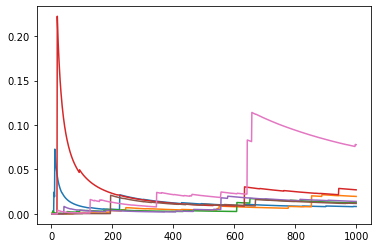

In [20]:
t = 20.
s = 1000
p = Process(rates)
trajectories = 7
d = [[] for i in range(trajectories)]

partialsum = 0

for traj in range(trajectories):

    partialsum = 0
    
    for i in range(1, s):
    
        partialsum += sum(jarzy(t, 1, p))

        d[traj].append(partialsum / i)
        
    plt.plot(range(1, s), d[traj])

plt.show()


### Fluctuation-dissipation theorem

We are finally in the position to use this stuff to prove the simplest of all results.

In [ ]:
t = 100.
samples = 100000

half_bins = 40
q_max = 10
step = q_max / (2 * half_bins)
q_range = [(- half_bins + k ) * step for k in range(2 * half_bins + 1)]

values, c_values = [], []
first = True

for q in q_range:
    
    newrates = [x.copy() for x in rates]
    newrates[0][1] *= exp(q)
    p = Process(newrates)

    currents = []
    
    for k in range(samples): 
        o = Observe(p, t)
        currents.append(o.currents()[0][1])
        
    c_var = variance(currents) / t
    
    if first:
        c_mean = mean(currents) / t
        first = False
        
    else:
        c_newmean = mean(currents) / t
        values.append(-(2 * (c_newmean - c_mean) / c_var) / step))
        c_mean = c_newmean
        
    c_values.append(c_mean)

plt.axhline(0, color = 'black')
plt.plot(q_range, c_values, 'o')
plt.show()

plt.axhline(1, color = 'black')
q_range.pop(0)
plt.plot(q_range, values, 'o')
plt.show()


## Chapter 11: Cloning, adapting, and all that

### Importance sampling

For a given process and a given number of iterations, samples, and small time interval, this function returns the estimator of the SCGF at some value $q$, and the estimator of the final population.

In [ ]:
def scgf_clone(p, q, t, iterations, samples, a = 0, b = 1):

    clones = exp(t * p.rates[a][b] * (exp(q) - 1))
    p.rates[a][b] = p.rates[a][b] * exp(q)
    
    estimator = 0

    for j in range(iterations):

        p = Process(p.rates, p.start)
        
        occupation = [0, 0, 0, 0]
        
        for k in range(samples):
            
            o = Observe(t, p)
            x = o.states[-1]
            occupation[x] += 1

        occupation = [x / samples for x in occupation]    
        occupation[a] *= clones           
        norm = sum(occupation)
        estimator += log(norm)
        
        p.start = [x / norm for x in occupation]
                   
    return estimator / (t * iterations), p.start


def scgf_estimate(p, q, t, s, transitions = [(0, 1)], weights = [1]):
    
    estimator = 0
    
    for k in range(s):
        o = Observe(t, p)
        fluxes = o.fluxes(transitions)
        
        for j in fluxes:
            i = transitions.index(j)
            estimator += exp(q * weights[i] * fluxes[j]) / samples
        
    return log(estimator) / t
    
    

To compare results with the analytical expression, we solve for the dominant eigenvalue of the SCGF:

We now employ the function:

Let's also plot the normalized commutator

The systematic error is becoming more and more important where the algorithm is required to perform better. For this reason it is preferred to choose another measure.

# Adaptive sampling

## Chapter 14: Survival and first-transition time probabilities

First we estimate the survival probability of being at a steate $y$ at time $t$, starting from state $x$, and assuming that the transition $0 \to 1$ does not occur. We do this by first defining the function:

Also, we will compare to theoretical prediction $\exp tS$, where $S$ is the matrix obtained by setting to zero the off-diagonal entries that correspond to the taboo transitions:

Now we can estimate the survival probabilibites and compare to theory:

Let us now focus on first transition times. Now we calculate the time $t$ that it takes time for transition $0 \to 1$ to occur for the first time.

Let us now visualize both:

We can also confirm that the normalization is correct:

### Cycle times

## Outdated stuff

This is outdated now: